## Recommender System for Book Crossing

### Overview and definition of the problem

The goal of this data science project is to build a recommender system for book crossing by predicting the user’s preferences. The recommender system explores the relationships between users and items with the result of creating a top-N recommendation list for a specific user. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Image

Loading books, users and ratings data.

In [2]:
books = pd.read_csv('/Users/nathalie.nguyen/Documents/GitHub/recommender_system/recsys/data/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding='latin-1', low_memory=False)
users = pd.read_csv('/Users/nathalie.nguyen/Documents/GitHub/recommender_system/recsys/data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1', low_memory=False)
ratings = pd.read_csv('/Users/nathalie.nguyen/Documents/GitHub/recommender_system/recsys/data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1', low_memory=False)
pd.set_option('display.max_colwidth', -1)

In [3]:
print('books:', books.shape)
print('users:', users.shape)
print('ratings:', ratings.shape)

books: (271379, 8)
users: (278858, 3)
ratings: (1149780, 3)


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [5]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
users_ratings_merged = users.merge(ratings, left_on='User-ID', right_on='User-ID', how='inner')

In [8]:
users_ratings_merged.head()

,User-ID,Location,Age,ISBN,Book-Rating
0,2,"stockton, california, usa",18.0,0195153448,0
1,7,"washington, dc, usa",NaN,034542252,0
2,8,"timmins, ontario, canada",NaN,0002005018,5
3,8,"timmins, ontario, canada",NaN,0060973129,0
4,8,"timmins, ontario, canada",NaN,0374157065,0


### Data Cleaning and Preparation

#### Cleaning the books data

- Two publisher names have been incorrectly loaded as 'Year-Of-Publication'. I will correct these data records by inserting them into the correct columns (as well as the corresponding values of the other columns).
- 'Year-Of-Publication' has values ranging from 0–2050. For all the invalid entries (0 and > 2018), I will convert these to NaNs and then replace them with mean values of remaining years. The data type will be set as int.
- Some data records (publisher and author) contain NaN. The missing publisher names will replaced with the looked up ones; the missing author name couldn't be found out and therefore will be replaced with 'other'.

In [9]:
print(sorted(books['Year-Of-Publication'].unique()))

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


In [10]:
books[books.isnull().any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg
187700,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.LZZZZZZZ.jpg
209550,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
220744,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le Clï¿½?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN
221691,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


#### Cleaning the users data

- 'Age' has NaN and some very low and high values. Ages below 5 and above 90 will be replaced with NaNs and then filled with mean values of remaining ages. The data type will be set as int.

In [11]:
print(sorted(users['Age'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

#### Cleaning the ratings data

- The entries in the ratings data are correct.

In [12]:
print(sorted(ratings['Book-Rating'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Data Exploration

- Ratings data: Explicit ratings are represented by 1–10 and implicit ratings represented by 0. Since I will be using only explicit ratings for building the recommender system I will split the ratings in two parts. The ratings are matched with the ISBN and User-ID from the respective tables. <br> The plot shows that higher values are more common and rating 8 has been submitted most frequently.

In [13]:
ratings_new = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]

In [14]:
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

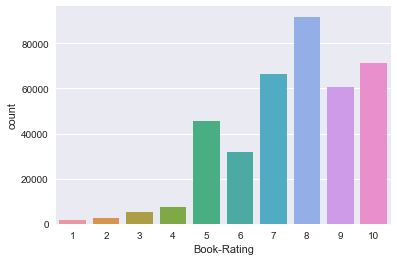

In [15]:
sns.countplot(data=ratings_explicit, x='Book-Rating');

- Ages data:

### Popularity-based recommendations

In [16]:
ratings_new = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [17]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_count.sort_values('Book-Rating', ascending=False).head(10)
top10_books_merged = top10.merge(books, left_on='ISBN', right_on='ISBN', how='left')
top10_books_merged.index = top10_books_merged.index + 1

In [18]:
top10_books_merged[['Book-Title', 'Book-Author']]

,Book-Title,Book-Author
1,The Lovely Bones: A Novel,Alice Sebold
2,The Da Vinci Code,Dan Brown
3,The Red Tent (Bestselling Backlist),Anita Diamant
4,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling
5,The Secret Life of Bees,Sue Monk Kidd
6,Wild Animus,Rich Shapero
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells
8,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts
9,Girl with a Pearl Earring,Tracy Chevalier
10,Angels & Demons,Dan Brown


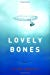

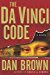

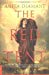

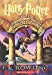

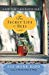

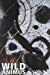

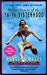

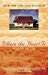

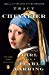

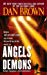

In [19]:
top10_images = np.array(top10_books_merged['Image-URL-S'])
for img in top10_images:
    display(Image(img))